##### Channel/Ranged Trading strategy 

[*********************100%***********************]  1 of 1 completed


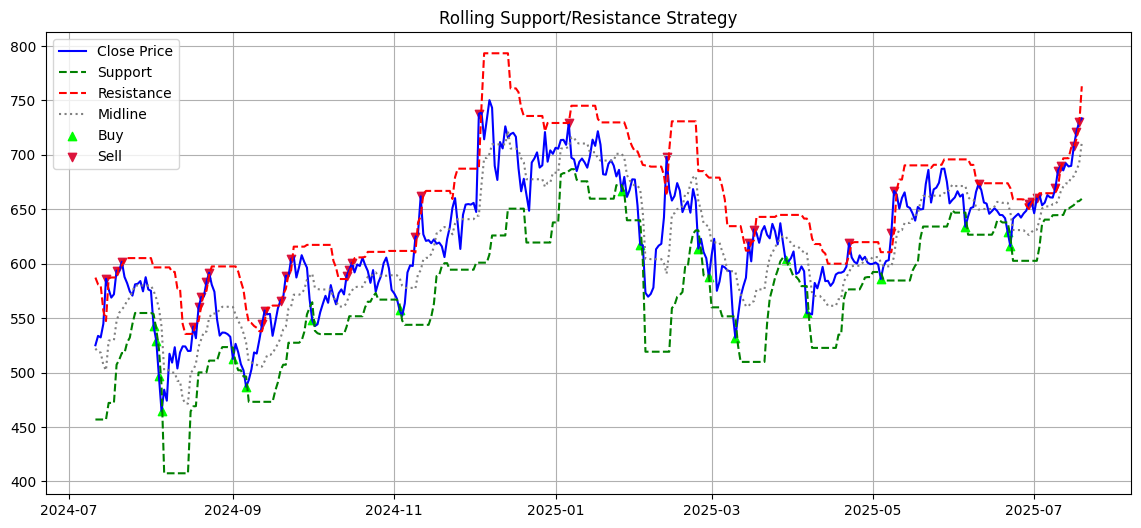

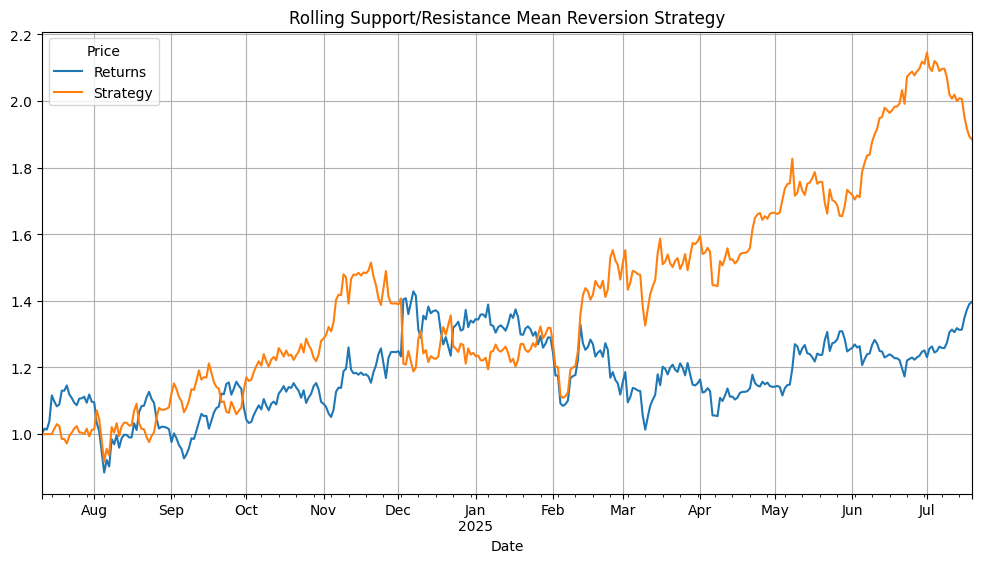

In [793]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# [ltc, btc, eth]

ticker = "BNB-USD"
start = "2024-07-01"
end = "2025-07-20"

def download_data(start, end, ticker):
    data = yf.download(ticker, start=start, end=end, interval="1d", auto_adjust=False)
    if data.empty:
        print("No data fetched. Check ticker, interval, or date range.")
        return pd.DataFrame()
    
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data



def compute_rolling_levels(data, window=20):
    data['Support'] = data['Low'].rolling(window).min().shift(1)
    data['Resistance'] = data['High'].rolling(window).max().shift(1)
    data['Mid'] = (data['Support'] + data['Resistance']) / 2
    return data


def generate_signals(data):
    data = data.copy()
    data = data.dropna(subset=['Support', 'Resistance'])

    # Signal: 1 for Buy, -1 for Sell, 0 for Neutral
    data['Signal'] = 0
    data.loc[data['Close'] <= data['Support'], 'Signal'] = 1
    data.loc[data['Close'] >= data['Resistance'], 'Signal'] = -1

    # Exit: -1 to close long, +1 to close short
    data['Exit'] = 0
    data['Prev_Position'] = 0

    for i in range(1, len(data)):
        prev_pos = data.at[data.index[i-1], 'Signal'] if data.at[data.index[i-1], 'Signal'] != 0 else data.at[data.index[i-1], 'Prev_Position']
        data.at[data.index[i], 'Prev_Position'] = prev_pos

        if prev_pos == 1 and data['Close'].iloc[i] >= data['Resistance'].iloc[i]:
            data.at[data.index[i], 'Exit'] = -1  # Exit long at resistance
        elif prev_pos == -1 and data['Close'].iloc[i] <= data['Support'].iloc[i]:
            data.at[data.index[i], 'Exit'] = 1  # Exit short at support

    # Position tracking
    data['Position'] = 0
    position = 0

    for i in range(1, len(data)):
        if data['Signal'].iloc[i] == 1:
            position = 1
        elif data['Signal'].iloc[i] == -1:
            position = -1
        elif data['Exit'].iloc[i] != 0:
            position = 0
        data.at[data.index[i], 'Position'] = position

    data.drop(columns=['Prev_Position'], inplace=True)
    return data


def backtest(data):
    data['Returns'] = data['Close'].pct_change().fillna(0)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    (1 + data[['Returns', 'Strategy']]).cumprod().plot(figsize=(12, 6), title='Rolling Support/Resistance Mean Reversion Strategy')
    plt.grid()
    plt.show()


def plot_signals(data):
    plt.figure(figsize=(14, 6))
    plt.plot(data['Close'], label='Close Price', color='blue')
    plt.plot(data['Support'], label='Support', linestyle='--', color='green')
    plt.plot(data['Resistance'], label='Resistance', linestyle='--', color='red')
    plt.plot(data['Mid'], label='Midline', linestyle=':', color='gray')

    # Buy/Sell markers
    plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], label='Buy', marker='^', color='lime')
    plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], label='Sell', marker='v', color='crimson')

    plt.title("Rolling Support/Resistance Strategy")
    plt.legend()
    plt.grid()
    plt.show()


# Run the strategy
if __name__ == "__main__":
    df = download_data(start=start, end=end, ticker=ticker)
    df = compute_rolling_levels(df, window=10)
    df = generate_signals(df)
    plot_signals(df)
    backtest(df)


##### Creating Machine Learning Model from for trend direction

In [794]:
df

Price,Adj Close,Close,High,Low,Open,Volume,Support,Resistance,Mid,Signal,Exit,Position,Returns,Strategy
Date,,,,,,,,,,,,,,
2024-07-11,525.138062,525.138062,540.079224,521.037964,524.576721,1685684515,456.923401,587.281189,522.102295,0,0,0,0.000000,NaN
2024-07-12,533.757324,533.757324,537.316162,517.993286,525.117126,1600204226,456.923401,581.034729,518.979065,0,0,0,0.016413,0.000000
2024-07-13,532.348816,532.348816,539.199646,527.764832,533.761414,1436156860,456.923401,579.935364,518.429382,0,0,0,-0.002639,-0.000000
2024-07-14,544.818726,544.818726,547.358582,532.110229,532.378540,1486806663,456.923401,556.892761,506.908081,0,0,0,0.023424,0.000000
2024-07-15,586.141052,586.141052,586.543579,544.700806,544.920898,2019082961,456.923401,547.358582,502.140991,-1,0,-1,0.075846,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-15,689.921143,689.921143,692.943176,675.876709,689.416748,2167202399,652.340149,706.713318,679.526733,0,0,-1,0.000732,-0.000732
2025-07-16,708.126099,708.126099,714.790894,685.676147,689.921143,2298649454,653.873657,706.713318,680.293488,-1,0,-1,0.026387,-0.026387
2025-07-17,721.211975,721.211975,726.660645,707.889771,708.126099,2877681453,657.106079,714.790894,685.948486,-1,0,-1,0.018480,-0.018480


In [795]:
import numpy as np

df["returns_difference"] = df["Returns"].diff()
df["trend_direction"] = np.where(df["returns_difference"].shift(-1) > 0, 1, 0)


In [796]:
df

Price,Adj Close,Close,High,Low,Open,Volume,Support,Resistance,Mid,Signal,Exit,Position,Returns,Strategy,returns_difference,trend_direction
Date,,,,,,,,,,,,,,,,
2024-07-11,525.138062,525.138062,540.079224,521.037964,524.576721,1685684515,456.923401,587.281189,522.102295,0,0,0,0.000000,NaN,NaN,1
2024-07-12,533.757324,533.757324,537.316162,517.993286,525.117126,1600204226,456.923401,581.034729,518.979065,0,0,0,0.016413,0.000000,0.016413,0
2024-07-13,532.348816,532.348816,539.199646,527.764832,533.761414,1436156860,456.923401,579.935364,518.429382,0,0,0,-0.002639,-0.000000,-0.019052,1
2024-07-14,544.818726,544.818726,547.358582,532.110229,532.378540,1486806663,456.923401,556.892761,506.908081,0,0,0,0.023424,0.000000,0.026063,1
2024-07-15,586.141052,586.141052,586.543579,544.700806,544.920898,2019082961,456.923401,547.358582,502.140991,-1,0,-1,0.075846,0.000000,0.052422,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-15,689.921143,689.921143,692.943176,675.876709,689.416748,2167202399,652.340149,706.713318,679.526733,0,0,-1,0.000732,-0.000732,0.004796,1
2025-07-16,708.126099,708.126099,714.790894,685.676147,689.921143,2298649454,653.873657,706.713318,680.293488,-1,0,-1,0.026387,-0.026387,0.025655,0
2025-07-17,721.211975,721.211975,726.660645,707.889771,708.126099,2877681453,657.106079,714.790894,685.948486,-1,0,-1,0.018480,-0.018480,-0.007907,0


In [797]:
from sklearn.model_selection import train_test_split

In [798]:
from sklearn.preprocessing import StandardScaler

In [799]:
X = df.iloc[:,1:6].to_numpy()
Y = df.iloc[:,-1].to_numpy()
X,Y

(array([[5.25138062e+02, 5.40079224e+02, 5.21037964e+02, 5.24576721e+02,
         1.68568452e+09],
        [5.33757324e+02, 5.37316162e+02, 5.17993286e+02, 5.25117126e+02,
         1.60020423e+09],
        [5.32348816e+02, 5.39199646e+02, 5.27764832e+02, 5.33761414e+02,
         1.43615686e+09],
        ...,
        [7.21211975e+02, 7.26660645e+02, 7.07889771e+02, 7.08126099e+02,
         2.87768145e+09],
        [7.30216370e+02, 7.63054810e+02, 7.20235596e+02, 7.21211975e+02,
         3.40738300e+09],
        [7.33529053e+02, 7.42331787e+02, 7.21087036e+02, 7.30260803e+02,
         2.06769109e+09]], shape=(374, 5)),
 array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
     

In [800]:
X.shape, Y.shape

((374, 5), (374,))

In [801]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [802]:
X_train

array([[6.28302490e+02, 6.43664307e+02, 6.13567139e+02, 6.24374695e+02,
        2.96566864e+09],
       [6.01164185e+02, 6.03505066e+02, 5.95829651e+02, 5.99929016e+02,
        1.44481883e+09],
       [6.55255737e+02, 6.59311768e+02, 6.41312317e+02, 6.56252014e+02,
        1.96455821e+09],
       ...,
       [7.33529053e+02, 7.42331787e+02, 7.21087036e+02, 7.30260803e+02,
        2.06769109e+09],
       [6.44948486e+02, 6.46851807e+02, 6.08621460e+02, 6.13587280e+02,
        2.39361086e+09],
       [5.83051880e+02, 5.89416565e+02, 5.61224304e+02, 5.70019714e+02,
        1.99839442e+09]], shape=(299, 5))

In [803]:
from sklearn.linear_model import LogisticRegression

In [804]:
sc = StandardScaler()

In [805]:
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 0.13152139,  0.2108359 ,  0.09543423,  0.09004636,  1.85016761],
       [-0.33116283, -0.46536674, -0.20753941, -0.32939223, -0.75707572],
       [ 0.59105052,  0.47430837,  0.569349  ,  0.63699693,  0.13393076],
       ...,
       [ 1.92554163,  1.87220224,  1.93197922,  1.90683863,  0.31073488],
       [ 0.41532096,  0.26450713,  0.0109572 , -0.09504394,  0.86946997],
       [-0.63996168, -0.70258939, -0.79863257, -0.84257559,  0.19193729]],
      shape=(299, 5))

In [806]:
model = LogisticRegression()
model.fit(X_train,Y_train)

LogisticRegression()

In [807]:
Y_pred = model.predict(X_test)


In [808]:
Y_test

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1])

In [809]:
Y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1])

In [810]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.72


#### Integrating the model with the strategy

In [811]:
df["predicted_direction"] = model.predict(X)

In [812]:
df

Price,Adj Close,Close,High,Low,Open,Volume,Support,Resistance,Mid,Signal,Exit,Position,Returns,Strategy,returns_difference,trend_direction,predicted_direction
Date,,,,,,,,,,,,,,,,,
2024-07-11,525.138062,525.138062,540.079224,521.037964,524.576721,1685684515,456.923401,587.281189,522.102295,0,0,0,0.000000,NaN,NaN,1,0
2024-07-12,533.757324,533.757324,537.316162,517.993286,525.117126,1600204226,456.923401,581.034729,518.979065,0,0,0,0.016413,0.000000,0.016413,0,0
2024-07-13,532.348816,532.348816,539.199646,527.764832,533.761414,1436156860,456.923401,579.935364,518.429382,0,0,0,-0.002639,-0.000000,-0.019052,1,0
2024-07-14,544.818726,544.818726,547.358582,532.110229,532.378540,1486806663,456.923401,556.892761,506.908081,0,0,0,0.023424,0.000000,0.026063,1,0
2024-07-15,586.141052,586.141052,586.543579,544.700806,544.920898,2019082961,456.923401,547.358582,502.140991,-1,0,-1,0.075846,0.000000,0.052422,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-15,689.921143,689.921143,692.943176,675.876709,689.416748,2167202399,652.340149,706.713318,679.526733,0,0,-1,0.000732,-0.000732,0.004796,1,0
2025-07-16,708.126099,708.126099,714.790894,685.676147,689.921143,2298649454,653.873657,706.713318,680.293488,-1,0,-1,0.026387,-0.026387,0.025655,0,0
2025-07-17,721.211975,721.211975,726.660645,707.889771,708.126099,2877681453,657.106079,714.790894,685.948486,-1,0,-1,0.018480,-0.018480,-0.007907,0,0


In [813]:
df.drop(columns=["Signal", "Exit", "Position", "Returns", "Strategy", "returns_difference", "trend_direction"], inplace=True)

In [814]:
df

Price,Adj Close,Close,High,Low,Open,Volume,Support,Resistance,Mid,predicted_direction
Date,,,,,,,,,,
2024-07-11,525.138062,525.138062,540.079224,521.037964,524.576721,1685684515,456.923401,587.281189,522.102295,0
2024-07-12,533.757324,533.757324,537.316162,517.993286,525.117126,1600204226,456.923401,581.034729,518.979065,0
2024-07-13,532.348816,532.348816,539.199646,527.764832,533.761414,1436156860,456.923401,579.935364,518.429382,0
2024-07-14,544.818726,544.818726,547.358582,532.110229,532.378540,1486806663,456.923401,556.892761,506.908081,0
2024-07-15,586.141052,586.141052,586.543579,544.700806,544.920898,2019082961,456.923401,547.358582,502.140991,0
...,...,...,...,...,...,...,...,...,...,...
2025-07-15,689.921143,689.921143,692.943176,675.876709,689.416748,2167202399,652.340149,706.713318,679.526733,0
2025-07-16,708.126099,708.126099,714.790894,685.676147,689.921143,2298649454,653.873657,706.713318,680.293488,0
2025-07-17,721.211975,721.211975,726.660645,707.889771,708.126099,2877681453,657.106079,714.790894,685.948486,0


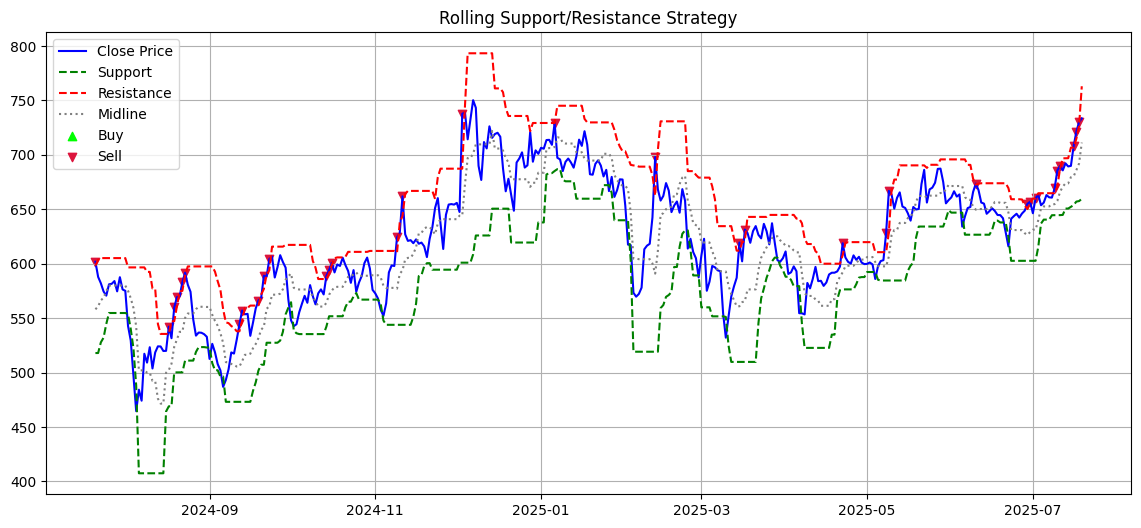

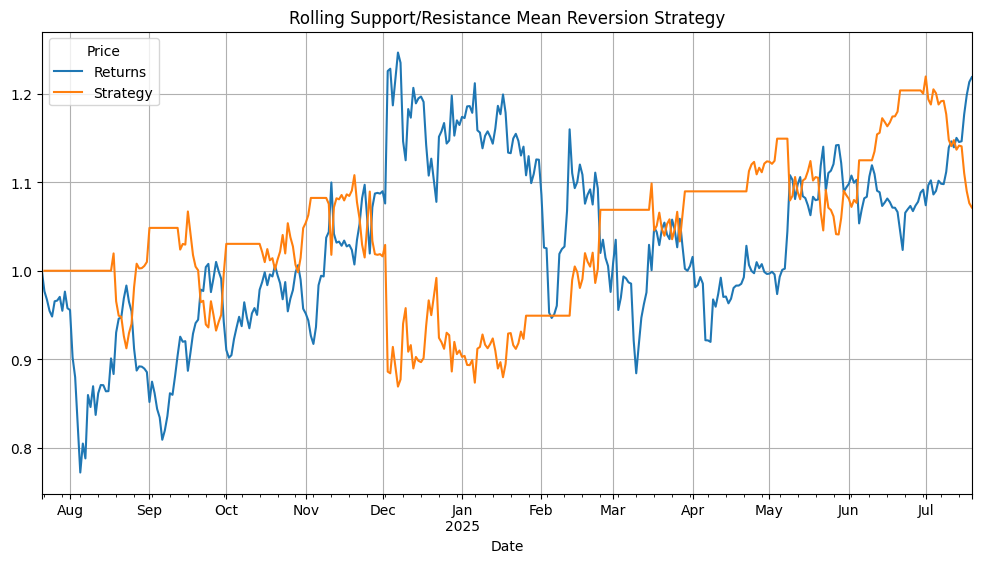

0.1327618026162276


In [815]:

def generate_signals(data):
    data = data.copy()
    data = data.dropna(subset=['Support', 'Resistance'])

    # Signal: 1 for Buy, -1 for Sell, 0 for Neutral
    data['Signal'] = 0

    # Long Entry Condition
    data.loc[
        (data['Close'] <= data['Support']) &
        (data['predicted_direction'] == 1),
        'Signal'
    ] = 1

    # Short Entry Condition
    data.loc[
        (data['Close'] >= data['Resistance']) &
        (data['predicted_direction'] == 0),
        'Signal'
    ] = -1

    # Exit logic
    data['Exit'] = 0
    data['Prev_Position'] = 0

    for i in range(1, len(data)):
        prev_pos = data.at[data.index[i-1], 'Signal'] if data.at[data.index[i-1], 'Signal'] != 0 else data.at[data.index[i-1], 'Prev_Position']
        data.at[data.index[i], 'Prev_Position'] = prev_pos

        if prev_pos == 1 and data['Close'].iloc[i] >= data['Resistance'].iloc[i]:
            data.at[data.index[i], 'Exit'] = -1  # Exit long at resistance
        elif prev_pos == -1 and data['Close'].iloc[i] <= data['Support'].iloc[i]:
            data.at[data.index[i], 'Exit'] = 1  # Exit short at support

    # Position tracking
    data['Position'] = 0
    position = 0

    for i in range(1, len(data)):
        if data['Signal'].iloc[i] == 1:
            position = 1
        elif data['Signal'].iloc[i] == -1:
            position = -1
        elif data['Exit'].iloc[i] != 0:
            position = 0
        data.at[data.index[i], 'Position'] = position

    data.drop(columns=['Prev_Position'], inplace=True)
    return data


def backtest(data):
    data['Returns'] = data['Close'].pct_change().fillna(0)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    (1 + data[['Returns', 'Strategy']]).cumprod().plot(figsize=(12, 6), title='Rolling Support/Resistance Mean Reversion Strategy')
    plt.grid()
    plt.show()


def plot_signals(data):
    plt.figure(figsize=(14, 6))
    plt.plot(data['Close'], label='Close Price', color='blue')
    plt.plot(data['Support'], label='Support', linestyle='--', color='green')
    plt.plot(data['Resistance'], label='Resistance', linestyle='--', color='red')
    plt.plot(data['Mid'], label='Midline', linestyle=':', color='gray')

    # Buy/Sell markers
    plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], label='Buy', marker='^', color='lime')
    plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], label='Sell', marker='v', color='crimson')

    plt.title("Rolling Support/Resistance Strategy")
    plt.legend()
    plt.grid()
    plt.show()


# Run the strategy
if __name__ == "__main__":
    df = compute_rolling_levels(df, window=10)
    df = generate_signals(df)
    plot_signals(df)
    backtest(df)
    print(df["Strategy"].sum())